In [2]:
import tensorflow as tf
tf.enable_eager_execution()

In [3]:
from __future__ import absolute_import, division, print_function

import random
import pathlib
import IPython.display as display

tf.VERSION

'1.13.1'

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
data_root = tf.keras.utils.get_file('flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', untar=True)
data_root = pathlib.Path(data_root)
print(data_root)

/home/maksym/.keras/datasets/flower_photos


In [6]:
for item in data_root.iterdir():
  print(item)

/home/maksym/.keras/datasets/flower_photos/daisy
/home/maksym/.keras/datasets/flower_photos/dandelion
/home/maksym/.keras/datasets/flower_photos/LICENSE.txt
/home/maksym/.keras/datasets/flower_photos/tulips
/home/maksym/.keras/datasets/flower_photos/sunflowers
/home/maksym/.keras/datasets/flower_photos/roses


In [7]:
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [8]:
all_image_paths[:10]

['/home/maksym/.keras/datasets/flower_photos/dandelion/14211880544_5d1f9d5aa8_n.jpg',
 '/home/maksym/.keras/datasets/flower_photos/tulips/13289268363_b9337d751e.jpg',
 '/home/maksym/.keras/datasets/flower_photos/dandelion/4607183665_3472643bc8.jpg',
 '/home/maksym/.keras/datasets/flower_photos/dandelion/1667963621_c76d570af3_n.jpg',
 '/home/maksym/.keras/datasets/flower_photos/sunflowers/50987813_7484bfbcdf.jpg',
 '/home/maksym/.keras/datasets/flower_photos/dandelion/480621885_4c8b50fa11_m.jpg',
 '/home/maksym/.keras/datasets/flower_photos/tulips/17282288501_e8738c9cfb_n.jpg',
 '/home/maksym/.keras/datasets/flower_photos/daisy/5109508979_68e3530791_m.jpg',
 '/home/maksym/.keras/datasets/flower_photos/roses/1485142251_ca89254442.jpg',
 '/home/maksym/.keras/datasets/flower_photos/dandelion/13887066460_64156a9021.jpg']

In [9]:
attributions = (data_root/"LICENSE.txt").read_text(encoding="utf8").splitlines()[4:]
attributions = [line.split(' CC-BY') for line in attributions]
attributions = dict(attributions)

In [10]:
def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return "Image (CC BY 2.0) " + ' - '.join(attributions[str(image_rel)].split(' - ')[:-1])

In [11]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [12]:
label_to_index = dict((name, index) for index, name  in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [13]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels in indices: ", all_image_labels[:10])

First 10 labels in indices:  [1, 4, 1, 1, 3, 1, 4, 0, 2, 1]


In [71]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, [224, 224])
    image /= 255.0
    
    return image

def load_and_preprocess_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

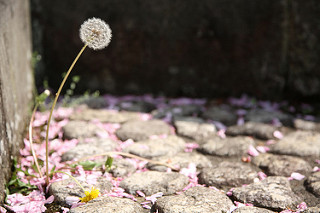

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt

image_path = all_image_paths[10]
label = all_image_labels[10]

display.Image(filename=image_path)

In [73]:
# Build a tf.data.Dataset

In [74]:
print(all_image_paths[:10])
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

['/home/maksym/.keras/datasets/flower_photos/dandelion/14211880544_5d1f9d5aa8_n.jpg', '/home/maksym/.keras/datasets/flower_photos/tulips/13289268363_b9337d751e.jpg', '/home/maksym/.keras/datasets/flower_photos/dandelion/4607183665_3472643bc8.jpg', '/home/maksym/.keras/datasets/flower_photos/dandelion/1667963621_c76d570af3_n.jpg', '/home/maksym/.keras/datasets/flower_photos/sunflowers/50987813_7484bfbcdf.jpg', '/home/maksym/.keras/datasets/flower_photos/dandelion/480621885_4c8b50fa11_m.jpg', '/home/maksym/.keras/datasets/flower_photos/tulips/17282288501_e8738c9cfb_n.jpg', '/home/maksym/.keras/datasets/flower_photos/daisy/5109508979_68e3530791_m.jpg', '/home/maksym/.keras/datasets/flower_photos/roses/1485142251_ca89254442.jpg', '/home/maksym/.keras/datasets/flower_photos/dandelion/13887066460_64156a9021.jpg']


In [75]:
print('shape: ', repr(path_ds.output_shapes))
print('type: ',repr(path_ds.output_types))
print()
print(path_ds)

shape:  TensorShape([])
type:  tf.string

<DatasetV1Adapter shapes: (), types: tf.string>


In [76]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

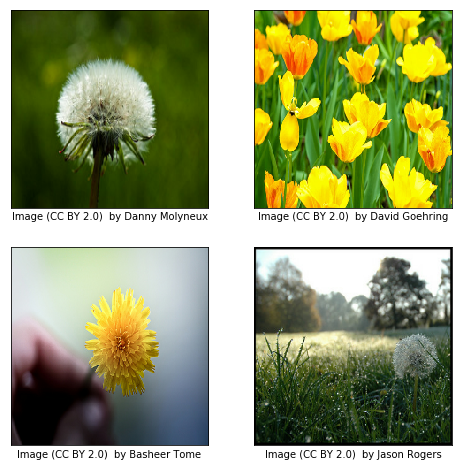

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n, image in enumerate(image_ds.take(4)):
    plt.subplot(2,2,n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(caption_image(all_image_paths[n]))

In [78]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [79]:
for label in label_ds.take(10):
    print(label_names[label.numpy()])

dandelion
tulips
dandelion
dandelion
sunflowers
dandelion
tulips
daisy
roses
dandelion


In [80]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [81]:
print('image shape: ', image_label_ds.output_shapes[0])
print('label shape: ', image_label_ds.output_shapes[1])
print('types: ', image_label_ds.output_types)
print()
print(image_label_ds)

image shape:  (224, 224, 3)
label shape:  ()
types:  (tf.float32, tf.int64)

<DatasetV1Adapter shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>


In [82]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<DatasetV1Adapter shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int32)>

In [83]:
BATCH_SIZE = 32
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<DatasetV1Adapter shapes: ((?, 224, 224, 3), (?,)), types: (tf.float32, tf.int32)>

In [84]:
ds = image_label_ds.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)

In [85]:
def change_range(image,label):
  return 2*image-1, label

keras_ds = ds.map(change_range)

In [86]:
image_batch, label_batch = next(iter(keras_ds))
type(image_batch)

tensorflow.python.framework.ops.EagerTensor

In [87]:
# Import Dependencies
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Activation,
                                     Dropout, Flatten,
                                     Conv2D, MaxPooling2D)
from tensorflow.layers import BatchNormalization
from tensorflow.nn import local_response_normalization

In [88]:
class AlexNet():
    
    def __init__(self):
        self.model = Sequential()
    
    def build(self):
        # 1st Convolutional Layer
        self.model.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11),
                         strides=(4,4), padding='valid'))
        self.model.add(Activation('relu'))
        # Pooling 
        self.model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
        # Batch Normalisation before passing it to the next layer
        self.model.add(BatchNormalization())

        # 2nd Convolutional Layer
        self.model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='valid'))
        self.model.add(Activation('relu'))
        # Pooling
        self.model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
        # Batch Normalisation
        self.model.add(BatchNormalization())

        # 3rd Convolutional Layer
        self.model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
        self.model.add(Activation('relu'))
        # Batch Normalisation
        self.model.add(BatchNormalization())

        # 4th Convolutional Layer
        self.model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
        self.model.add(Activation('relu'))
        # Batch Normalisation
        self.model.add(BatchNormalization())

        # 5th Convolutional Layer
        self.model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
        self.model.add(Activation('relu'))
        # Pooling
        self.model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
        # Batch Normalisation
        self.model.add(BatchNormalization())

        # Passing it to a dense layer
        self.model.add(Flatten())
        # 1st Dense Layer
        self.model.add(Dense(9216, input_shape=(224*224*3,)))
        self.model.add(Activation('relu'))
        # Add Dropout to prevent overfitting
        self.model.add(Dropout(0.4))
        # Batch Normalisation
        self.model.add(BatchNormalization())

        # 2nd Dense Layer
        self.model.add(Dense(4096))
        self.model.add(Activation('relu'))
        # Add Dropout
        self.model.add(Dropout(0.4))
        # Batch Normalisation
        self.model.add(BatchNormalization())

        # 3rd Dense Layer
        self.model.add(Dense(4096))
        self.model.add(Activation('relu'))
        # Add Dropout
        self.model.add(Dropout(0.4))
        # Batch Normalisation
        self.model.add(BatchNormalization())

        # Output Layer
        self.model.add(Dense(6))
        self.model.add(Activation('softmax'))
        self.model.summary()

In [89]:
alexnet_model = AlexNet()
alexnet_model.build()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 54, 54, 96)        34944     
_________________________________________________________________
activation_9 (Activation)    (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 23, 23, 256)       614656    
_________________________________________________________________
activation_10 (Activation)   (None, 23, 23, 256)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 11, 11, 256)       0         
__________

In [90]:
alexnet_model.model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [379]:
alexnet_model.model.fit(keras_ds, epochs=20, steps_per_epoch=115, batch_size=32)

Epoch 1/20
115/115 [==============================] - 477s 4s/step - loss: 1.1811 - acc: 0.5038
Epoch 2/20
115/115 [==============================] - 444s 4s/step - loss: 1.1291 - acc: 0.5421
Epoch 3/20
115/115 [==============================] - 446s 4s/step - loss: 1.1025 - acc: 0.5524
Epoch 4/20
115/115 [==============================] - 447s 4s/step - loss: 1.0602 - acc: 0.5622
Epoch 5/20
115/115 [==============================] - 447s 4s/step - loss: 1.0276 - acc: 0.5932
Epoch 6/20
115/115 [==============================] - 447s 4s/step - loss: 1.0025 - acc: 0.6098
Epoch 7/20
115/115 [==============================] - 446s 4s/step - loss: 0.9438 - acc: 0.6364
Epoch 8/20
115/115 [==============================] - 465s 4s/step - loss: 0.9301 - acc: 0.6351
Epoch 9/20
115/115 [==============================] - 447s 4s/step - loss: 0.9000 - acc: 0.6562
Epoch 10/20
115/115 [==============================] - 448s 4s/step - loss: 0.8749 - acc: 0.6562
Epoch 11/20
115/115 [==================

In [380]:
test_loss, test_acc = alexnet_model.model.evaluate(keras_ds, steps=5)

5/5 [==============================] - 28s 6s/step - loss: 0.6600 - acc: 0.7312


In [378]:
def plot_image(predictions_array, true_label, path):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = load_and_preprocess_image(all_image_paths[path])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(label_names[predicted_label],
                                100*np.max(predictions_array),
                                label_names[all_image_labels[true_label]],
                                color=color))

In [563]:
id = 75
img = load_and_preprocess_image(all_image_paths[id])
img = np.expand_dims(img, axis=0)
prediction = alexnet_model.model.predict(img)

In [564]:
prediction

array([[9.9670714e-01, 5.8951037e-04, 5.0853175e-04, 1.5101851e-05,
        2.1796902e-03, 5.9544777e-29]], dtype=float32)

In [565]:
np.argmax(prediction)

0

In [566]:
label_names[np.argmax(prediction)]

'daisy'

In [567]:
label_names[all_image_labels[id]]

'daisy'

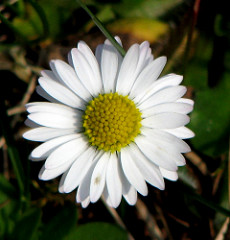

In [568]:
display.Image(filename=all_image_paths[id])

In [508]:
# serialize model to JSON
model_json = alexnet_model.model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [3]:
n = enumerate(('asd', 'asdas', 'yhyh'))

In [4]:
n